In [1]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agents.rbc import RBC

In [2]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [3]:
# Simulation without energy storage
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(4)])
cost_no_storage, cost_no_storage_last_yr = env.cost()

In [4]:
env.cost()

({'ramping': 1.0158848,
  '1-load_factor': 1.0555478376722895,
  'average_daily_peak': 1.1537274,
  'peak_demand': 1.0863601,
  'net_electricity_consumption': 0.9800154,
  'carbon_emissions': 0.9923097,
  'total': 1.0473075317438536,
  'coordination_score': 1.0778800259673735},
 {'ramping_last_yr': 1.0151572,
  '1-load_factor_last_yr': 1.055016834803665,
  'average_daily_peak_last_yr': 1.1594877,
  'peak_demand_last_yr': 1.0723878,
  'net_electricity_consumption_last_yr': 0.9813911,
  'carbon_emissions_last_yr': 0.99644214,
  'coordination_score_last_yr': 1.075512399094364,
  'total_last_yr': 1.0507707438419696})

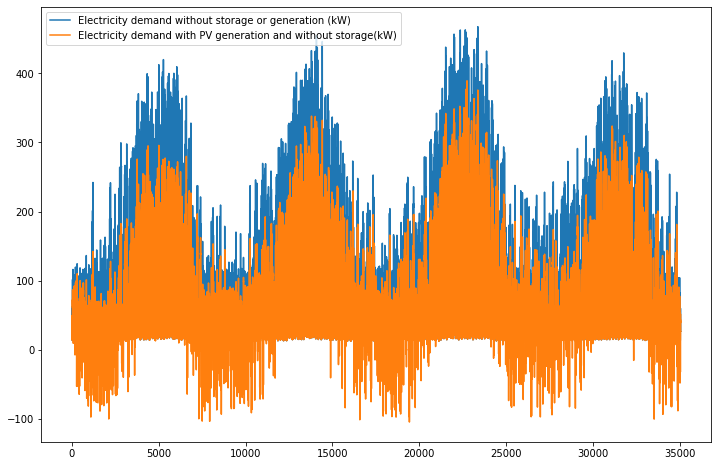

In [5]:
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])

In [6]:
# RULE-BASED CONTROLLER (RBC) (Stores energy at night and releases it during the day)
# In this example, each building has its own RBC, which tries to flatten a generic building load 
# by storing energy at night and using it during the day, which isn't necessarily the best solution 
# in order to flatten the total load of the district.
# Select the climate zone and load environment

'''IMPORTANT: Make sure that the buildings_state_action_space.json file contains the hour of day as 3rd true state:
{"Building_1": {
    "states": {
        "month": true,
        "day": true,
        "hour": true
Alternative, modify the line: "hour_day = states[0][2]" of the RBC_Agent Class in agent.py
'''
import json
import time
# Instantiating the control agent(s)
agents = RBC(actions_spaces)

# Finding which state 
with open('buildings_state_action_space.json') as file:
    actions_ = json.load(file)

indx_hour = -1
for obs_name, selected in list(actions_.values())[0]['states'].items():
    indx_hour += 1
    if obs_name=='hour':
        break
    assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
        

state = env.reset()
done = False
rewards_list = []
start = time.time()
while not done:
    hour_state = np.array([[state[0][indx_hour]]])
    action = agents.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()
end = time.time()
print(end-start)

28.216002464294434


In [7]:
1.18602800e-01 + 0.034*2

0.1866028

In [8]:
action[0][0]=0.034
action[0][1]=0.034
action[0][2]=0.034


In [9]:
next_state, rewards, done, _ = env.step(action)

IndexError: index 35039 is out of bounds for axis 0 with size 35039

In [10]:
action[0]

[0.034, 0.034, 0.034]

In [11]:
state[0]

array([ 1.20000000e+01,  1.00000000e+00,  2.40000000e+01,  7.50000000e-01,
        6.99000000e+00,  1.06900000e+01,  1.56000000e+00,  6.28800000e+01,
        9.78000000e+01,  6.23700000e+01,  5.90900000e+01,  0.00000000e+00,
       -0.00000000e+00,  6.72500000e+01, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.90600000e+01,
        3.84000000e+01,  9.28000000e+00,  0.00000000e+00,  9.36752157e-01,
        1.31673817e-01,  3.09754795e-02,  1.54688000e+01,  5.47135805e-01])

In [12]:
next_state[0]

array([ 1.20000000e+01,  1.00000000e+00,  2.40000000e+01,  7.50000000e-01,
        6.99000000e+00,  1.06900000e+01,  1.56000000e+00,  6.28800000e+01,
        9.78000000e+01,  6.23700000e+01,  5.90900000e+01,  0.00000000e+00,
       -0.00000000e+00,  6.72500000e+01, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.90600000e+01,
        3.84000000e+01,  9.28000000e+00,  0.00000000e+00,  9.36752157e-01,
        1.31673817e-01,  3.09754795e-02,  1.54688000e+01,  5.47135805e-01])

In [13]:
cost_rbc

({'ramping': 1.0,
  '1-load_factor': 1.0,
  'average_daily_peak': 1.0,
  'peak_demand': 1.0,
  'net_electricity_consumption': 1.0,
  'carbon_emissions': 1.0,
  'total': 1.0,
  'coordination_score': 1.0},
 {'ramping_last_yr': 1.0,
  '1-load_factor_last_yr': 1.0,
  'average_daily_peak_last_yr': 1.0,
  'peak_demand_last_yr': 1.0,
  'net_electricity_consumption_last_yr': 1.0,
  'carbon_emissions_last_yr': 1.0,
  'coordination_score_last_yr': 1.0,
  'total_last_yr': 1.0})

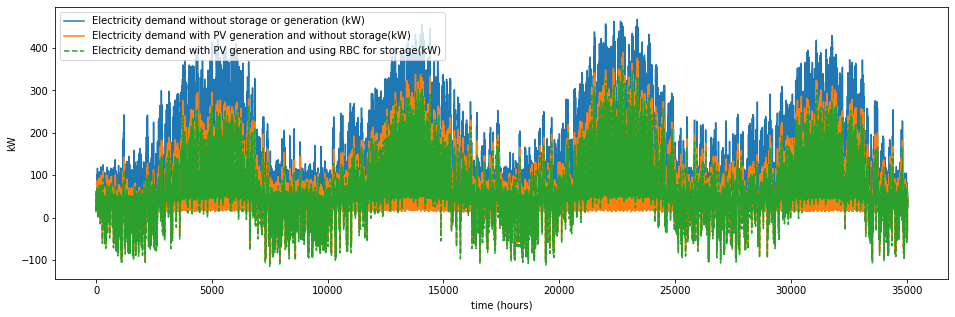

In [14]:
# Plotting electricity consumption breakdown
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

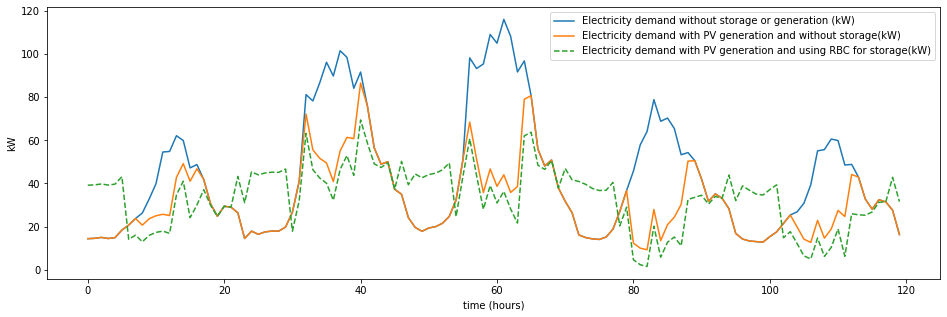

In [15]:
# Plotting 5 days of winter operation of year 1
plt.figure(figsize=(16,5))
interval = range(0,24*5)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

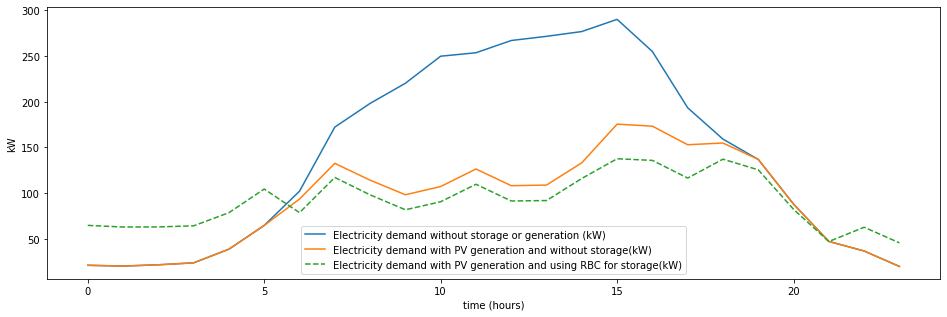

In [16]:
# Plotting summer operation of year 1
plt.figure(figsize=(16,5))
interval = range(24*30*7,24*30*7 + 24)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

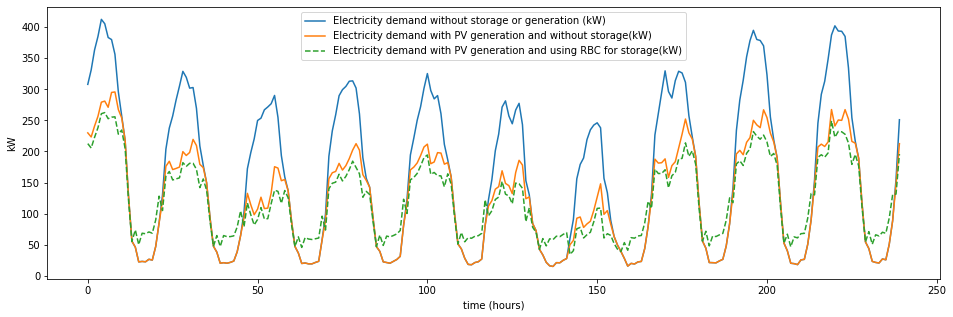

In [17]:
# Plotting summer operation
interval = range(5000,5000 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

In [18]:
# Plot for one building of the total cooling supply, the state of charge, and the actions of the controller during winter
building_number = 'Building_5'
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_storage_soc[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_device_to_building[3500:3500+24*5] + env.buildings[building_number].cooling_device_to_storage[3500:3500+24*5])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Building Cooling Demand (kWh)','Energy Storage State of Charge - SOC (kWh)', 'Heat Pump Total Cooling Supply (kW)'])

KeyError: 'Building_5'

<Figure size 864x576 with 0 Axes>

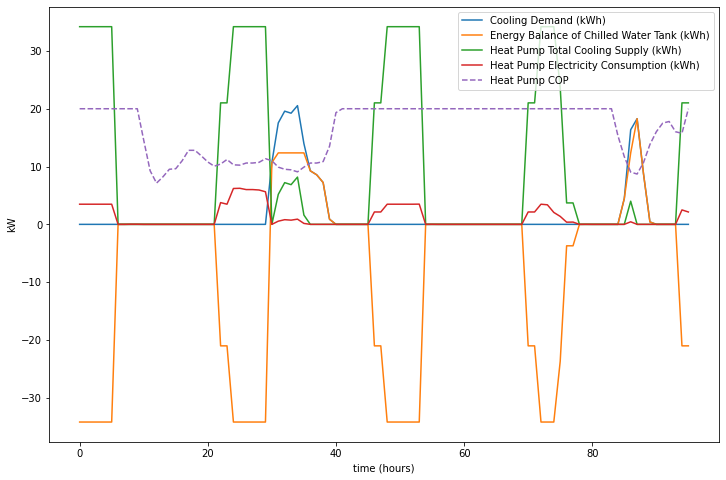

In [19]:
building_number = 'Building_1'
interval = range(0,24*4)
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[interval])
plt.plot(env.buildings[building_number].cooling_storage_to_building[interval] - env.buildings[building_number].cooling_device_to_storage[interval])
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[interval])
plt.plot(env.electric_consumption_cooling[interval])
plt.plot(env.buildings[building_number].cooling_device.cop_cooling[interval],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)','Energy Balance of Chilled Water Tank (kWh)', 'Heat Pump Total Cooling Supply (kWh)', 'Heat Pump Electricity Consumption (kWh)','Heat Pump COP'])